<h1 align="center"><strong><font size="6"> SFM: Performance Above replacement </h1></strong></font>

<br>

> Dissecting a Player's skill into *talent* and *grit*

> Calculating a Player's *Performance Above Replacement*

<br>

In [1]:
# --- Connect to Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>

## **0. &emsp; Load the Data**

In [2]:
import datetime

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import seaborn as sns
sns.set_style(style='darkgrid') # --- darkgrid; ticks; whitegrid
import xarray as xr

from sklearn.metrics import roc_auc_score
from matplotlib.lines import Line2D
from tqdm import tqdm


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 5]
%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "sfm"))
rng = np.random.default_rng(seed)

In [4]:
# ======================================= Load the Data ======================================= #

# --- Set your directory:
directory = '/content/drive/MyDrive/Colab Notebooks/51_SoccerAnalytics'

# --- Read the data:
data = pd.read_csv(f'{directory}/10_data/SFM_data.csv')


In [5]:
data.head()

,goal,goals_in_match,points_team,points_opp,goalsscored_cum_team,goalsscored_cum_opp,goalsconceded_cum_team,goalsconceded_cum_opp,home_pitch,goalsscored_rank_team,...,kickoff_dt,goalsscored_rank_opp,goalsconceded_rank_team,goalsscored_diff,goal_balance_team,goal_balance_opp,goal_balance_diff,points_diff,goalsscored_share_player_team,name_player
0,0.0,0.0,12.0,13.0,9.0,11.0,2.0,3.0,1.0,7.0,...,2003-09-21 16:05:00,4.0,7.0,-2.0,7.0,8.0,-1.0,-1.0,0.000000,cristiano ronaldo
1,0.0,0.0,19.0,8.0,16.0,8.0,3.0,17.0,0.0,2.0,...,2003-10-18 12:00:00,14.0,2.0,8.0,13.0,-9.0,22.0,11.0,0.000000,cristiano ronaldo
2,0.0,0.0,22.0,15.0,17.0,17.0,3.0,12.0,1.0,4.0,...,2003-10-25 00:00:00,4.0,4.0,0.0,14.0,5.0,9.0,7.0,0.000000,cristiano ronaldo
3,1.0,1.0,22.0,12.0,18.0,11.0,6.0,12.0,1.0,4.0,...,2003-11-01 00:00:00,11.0,4.0,7.0,12.0,-1.0,13.0,10.0,0.000000,cristiano ronaldo
4,0.0,0.0,28.0,11.0,23.0,17.0,7.0,22.0,1.0,2.0,...,2003-11-22 00:00:00,9.0,3.0,6.0,16.0,-5.0,21.0,17.0,0.043478,cristiano ronaldo


In [6]:
# =========================== Some additional Data Preparation =========================== #


# --- Create a 'player_season' indicator
data['player_season'] = data['name_player'] + [' '] + data['season']

# --- Get your Players' indices --> Now differentiated by Season!
player_idxs, players = pd.factorize(data.player_season)

coords = {"players": players, "obs_id":np.arange(len(player_idxs))}


In [7]:
# ======= Data Prep: 'Number of Seasons per Player' & 'Days since First Game (by Season)' ======= #

# --- Transform the kick-off date:
data["kickoff_dt"] = pd.to_datetime(data["kickoff_dt"], yearfirst=True)

# --- 'Number of Seasons per Player': ~maturity of player
data["season_nbr"] = data.groupby(['name_player'])['season'].transform(lambda x: x.factorize(sort=True)[0])

# --- 'Days since First Game (by Season)': aka within-season effects
data['days_since_first_game'] = data.groupby(['name_player', 'season'])['kickoff_dt'].transform(lambda x: (x - x.min()).dt.days)

data["goals_in_match"] = data["goals_in_match"].astype(int)

data = data.sort_values(["name_player", "kickoff_dt"]).reset_index(drop=True)


## **1. &emsp; Performance Above Replacement**

In [25]:
# =================================== USER INTERACTION =================================== #

class PAR():

  def __init__(self,params):
        super().__init__()

        # --- Store the parameters:
        self.coords = params['coords']
        self.data = params['data']
        self.days_sfg = params['days_sfg']
        self.player_idx = params['player_idx']
        self.factors_SFM = params['SFM_factors']


  # -------------------------------------- Set up the Model -------------------------------------- #
  def set_model(self):

    with pm.Model(coords=self.coords) as self.SFM_poisson:

        # Data containers
        seasons = pm.Data("seasons", self.data["season_nbr"].to_numpy(), dims="obs_id")
        days = pm.Data("days", self.days_sfg.to_numpy(), dims="obs_id")
        player_id = pm.Data("player_id", self.player_idx, dims="obs_id")
        factor_data = pm.Data("factor_data", self.factors_SFM.to_numpy(), dims=("obs_id", "factor"))
        goals_obs = pm.Data("goals_obs", self.data['goals_in_match'].to_numpy(), dims="obs_id")

        # player skills
        baseline = pm.Normal("baseline", mu=0, sigma=1, dims="player")
        maturity_effect = pm.Normal("maturity_effect", mu=0, sigma=0.5, dims="player")
        within_season_effect = pm.Normal("within_season_effect", mu=0, sigma=0.5, dims="player")
        alpha = pm.Deterministic(
            "alpha",
            baseline[player_id] + maturity_effect[player_id] * seasons + within_season_effect[player_id] * days,
            dims="obs_id"
        )

        # team factors
        beta = pm.Normal("beta", mu=0, sigma=0.5, dims="factor")

        # --- Probability of Scoring:
        scoring_rate = pm.Deterministic(
            'scoring_rate',
            pt.softplus(alpha + pm.math.dot(factor_data, beta)),
            dims="obs_id",
        )

        pm.Poisson("goals_scored", scoring_rate, observed=goals_obs, dims="obs_id")

        self.idata = pm.sample_prior_predictive()



  def sample_post(self):

    # --- Sample from the posterior
    with self.SFM_poisson:
      self.idata.extend(pm.sample())
      self.idata.extend(pm.sample_posterior_predictive(self.idata))


def get_standardize(data, my_vars):

  vars = my_vars + ['days_since_first_game']

  # --- --- Mean & SD of 'data'
  factors_mean = data[vars].mean(axis=0)
  factors_sd = data[vars].std(axis=0)

  # ---- --- Standardize 'data'
  data[vars] = (data[vars] - factors_mean) / factors_sd

  # ---- --- Store the Scaler:
  SFM_factors_scaler = {'factors':{'mean':factors_mean,'sd':factors_sd,'vars':vars}}

  return data, SFM_factors_scaler


def get_factors(data, vars, do_standardize=True):

  if do_standardize:

    factors_train = data[vars].astype(float)
    days_train = data["days_since_first_game"]

    # --- --- Mean & SD of 'data'
    factors_mean = factors_train.mean(axis=0)
    factors_sd = factors_train.std(axis=0)

    days_mean = data["days_since_first_game"].mean()
    days_sd = data["days_since_first_game"].std()

    # ---- --- Standardize 'data'
    factors_SFM = (factors_train - factors_mean) / factors_sd
    days_sfg = (days_train - days_mean) / days_sd

    # ---- --- Store the Scaler:
    SFM_factors_scaler = {'factors':{'mean':factors_mean,'sd':factors_sd},
                         'days':{'mean':days_mean,'sd':days_sd}}

  else:

    factors_SFM = data[vars].astype(float)
    days_sfg = data["days_since_first_game"]
    SFM_factors_scaler = {'factors':{'mean':0,'sd':1},
                         'days':{'mean':0,'sd':1}}


  return factors_SFM, days_sfg, SFM_factors_scaler


In [26]:
# =================================== USER INTERACTION =================================== #

# --- Specify your player/players of interest:
my_player = pd.unique(data['name_player']) #['cristiano ronaldo']

# --- Specify the reference group:
reference_group = pd.unique(data['name_player'])

# --- Define your explanatory variables [column names of 'data']:
my_vars = ['goalsscored_rank_team','goalsscored_rank_team_wo_player','home_pitch',
           'goalsconceded_rank_opp','points_diff','goal_balance_diff']

# --- Do you want to standardize your data?
I_want_stand = True

# =================================== USER INTERACTION =================================== #

In [27]:
data.head()

,goal,goals_in_match,points_team,points_opp,goalsscored_cum_team,goalsscored_cum_opp,goalsconceded_cum_team,goalsconceded_cum_opp,home_pitch,goalsscored_rank_team,...,goalsscored_diff,goal_balance_team,goal_balance_opp,goal_balance_diff,points_diff,goalsscored_share_player_team,name_player,player_season,season_nbr,days_since_first_game
0,1.0,2,11.0,3.0,7.0,5.0,3.0,12.0,0.982783,1.629110,...,2.0,4.0,-7.0,-0.079716,-0.029060,0.571429,alan shearer,alan shearer 1992/93,0,-1.599537
1,0.0,0,14.0,10.0,11.0,10.0,4.0,9.0,-1.017290,-0.050476,...,1.0,7.0,1.0,-0.317500,-0.302392,0.545455,alan shearer,alan shearer 1992/93,0,-1.500288
2,1.0,2,17.0,9.0,12.0,7.0,4.0,6.0,0.982783,-0.050476,...,5.0,8.0,1.0,-0.269944,-0.029060,0.500000,alan shearer,alan shearer 1992/93,0,-1.457752
3,1.0,1,17.0,5.0,14.0,8.0,7.0,12.0,-1.017290,-0.680321,...,6.0,7.0,-4.0,-0.079716,0.244272,0.571429,alan shearer,alan shearer 1992/93,0,-1.401038
4,1.0,1,18.0,11.0,15.0,18.0,8.0,17.0,0.982783,-0.260424,...,-3.0,7.0,1.0,-0.317500,-0.097393,0.600000,alan shearer,alan shearer 1992/93,0,-1.301789


In [28]:
# ================================== Calculate PAR for each Player in 'my_player' ================================== #

dict_PAR = {}

for pp in my_player:

  print(f'\nCalculating PAR for Player: {pp} ... Player {np.where(my_player == pp)[0][0]} out of {len(my_player)}\n')


  if 1==2:
    # ------------------------------- Option 1 ------------------------------- #
    # --- First: Exclude the data for 'pp' from the 'reference_group'
    data_reference = data.loc[data['name_player'].isin(reference_group),:].reset_index(drop=True)
    data_reference = data_reference.loc[~(data_reference['name_player'] == pp),:].reset_index(drop=True)
    # --- Second: Only take the data for 'pp'
    data_pp = data.loc[data['name_player'] == pp,:].reset_index(drop=True)

    # --- Third: Get the factors
    SFM_factors, days_sfg, SFM_factors_scaler = get_factors(data_reference, my_vars, do_standardize=I_want_stand)
    # --- Fourth: Scale the factors of player 'pp' accordingly:
    data_pp[my_vars] = (data_pp[my_vars] - SFM_factors_scaler['factors']['mean']) / SFM_factors_scaler['factors']['sd']
    data_pp['days_since_first_game'] = (data_pp['days_since_first_game'] - SFM_factors_scaler['days']['mean']) / SFM_factors_scaler['days']['sd']
  else:
    # ------------------------------- Option 2 ------------------------------- #
    # --- First: standardize the whole data
    data_stand, _ = get_standardize(data, my_vars)
    # --- Second: Exclude the data for 'pp' from the 'reference_group'
    data_reference = data_stand.loc[data['name_player'].isin(reference_group),:].reset_index(drop=True)
    data_reference = data_reference.loc[~(data_reference['name_player'] == pp),:].reset_index(drop=True)
    # --- Third: Only take the data for 'pp'
    data_pp = data_stand.loc[data['name_player'] == pp,:].reset_index(drop=True)
    # --- Fourth: Get the factors
    SFM_factors, days_sfg, SFM_factors_scaler = get_factors(data_reference, my_vars, do_standardize=False)


  # --- Fill the 'coords'
  player_idx, players = pd.factorize(data_reference.name_player)
  coords = {"player": players, "factor": my_vars, "obs_id": data_reference.index}


  # --- Instantiate the model
  my_model = PAR({'coords':{"player": players, "factor": my_vars, "obs_id": data_reference.index},
                  'data':data_reference,'days_sfg':days_sfg,'player_idx':player_idx,'SFM_factors':SFM_factors})

  # --- Set the model
  my_model.set_model()

  # --- Sample from the posterior
  my_model.sample_post()

  # --- Extract the coefficients (betas):
  beta_post = np.concatenate([my_model.idata['posterior']['beta'][0,:,:],my_model.idata['posterior']['beta'][1,:,:]])



  # --- Compute \delta_{i,t} for Player 'pp'
  delta_t_pp = np.array([data_pp['goals_in_match'] - data_pp[my_vars] @ beta_post[dd,:].T for dd in range(beta_post.shape[0])])

  # --- Compute \Delta_{i,t} for each player in the reference group
  delta_t_ref = np.array([data_reference['goals_in_match'] - data_reference[my_vars] @ beta_post[dd,:].T for dd in range(beta_post.shape[0])])


  # ------------------------------- Calculate PAR = P(delta_ref <= delta_pp) ------------------------------- #

  # --- Calculate 'delta_pp' as: median across all samples, then mean across all observations
  delta_pp = np.mean(np.median(delta_t_pp, axis=0))

  # --- Calculate 'delta_ref' as: median across all samples, then mean across all observations by player
  delta_t_ref_median = np.median(delta_t_ref, axis=0)
  delta_ref = pd.DataFrame({'name_player':data_reference['name_player'], 'delta_t_i':delta_t_ref_median}).groupby('name_player')['delta_t_i'].mean()

  # --- PAR:
  PAR_pp = sum(delta_ref <= delta_pp) / len(delta_ref)



  # ------------------------------------- Store the Output -------------------------------------- #
  dict_PAR[pp] = {'delta_t_pp':delta_t_pp,'delta_t_ref':delta_t_ref,
                  'delta_pp':delta_pp,'delta_ref':delta_ref,
                  'PAR_pp':PAR_pp}



Calculating PAR for Player: alan shearer ... Player 0 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: cristiano ronaldo ... Player 1 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: didier drogba ... Player 2 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: dimitar berbatov ... Player 3 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: fernando torres ... Player 4 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: harry kewell ... Player 5 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: jermain defoe ... Player 6 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: michael owen ... Player 7 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: nicolas anelka ... Player 8 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: robbie fowler ... Player 9 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: robbie keane ... Player 10 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: robert pires ... Player 11 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: robin van persie ... Player 12 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: ruud van nistelrooy ... Player 13 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: thierry henry ... Player 14 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: wayne rooney ... Player 15 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(



Calculating PAR for Player: zlatan ibrahimovic ... Player 16 out of 17



/usr/local/lib/python3.10/dist-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


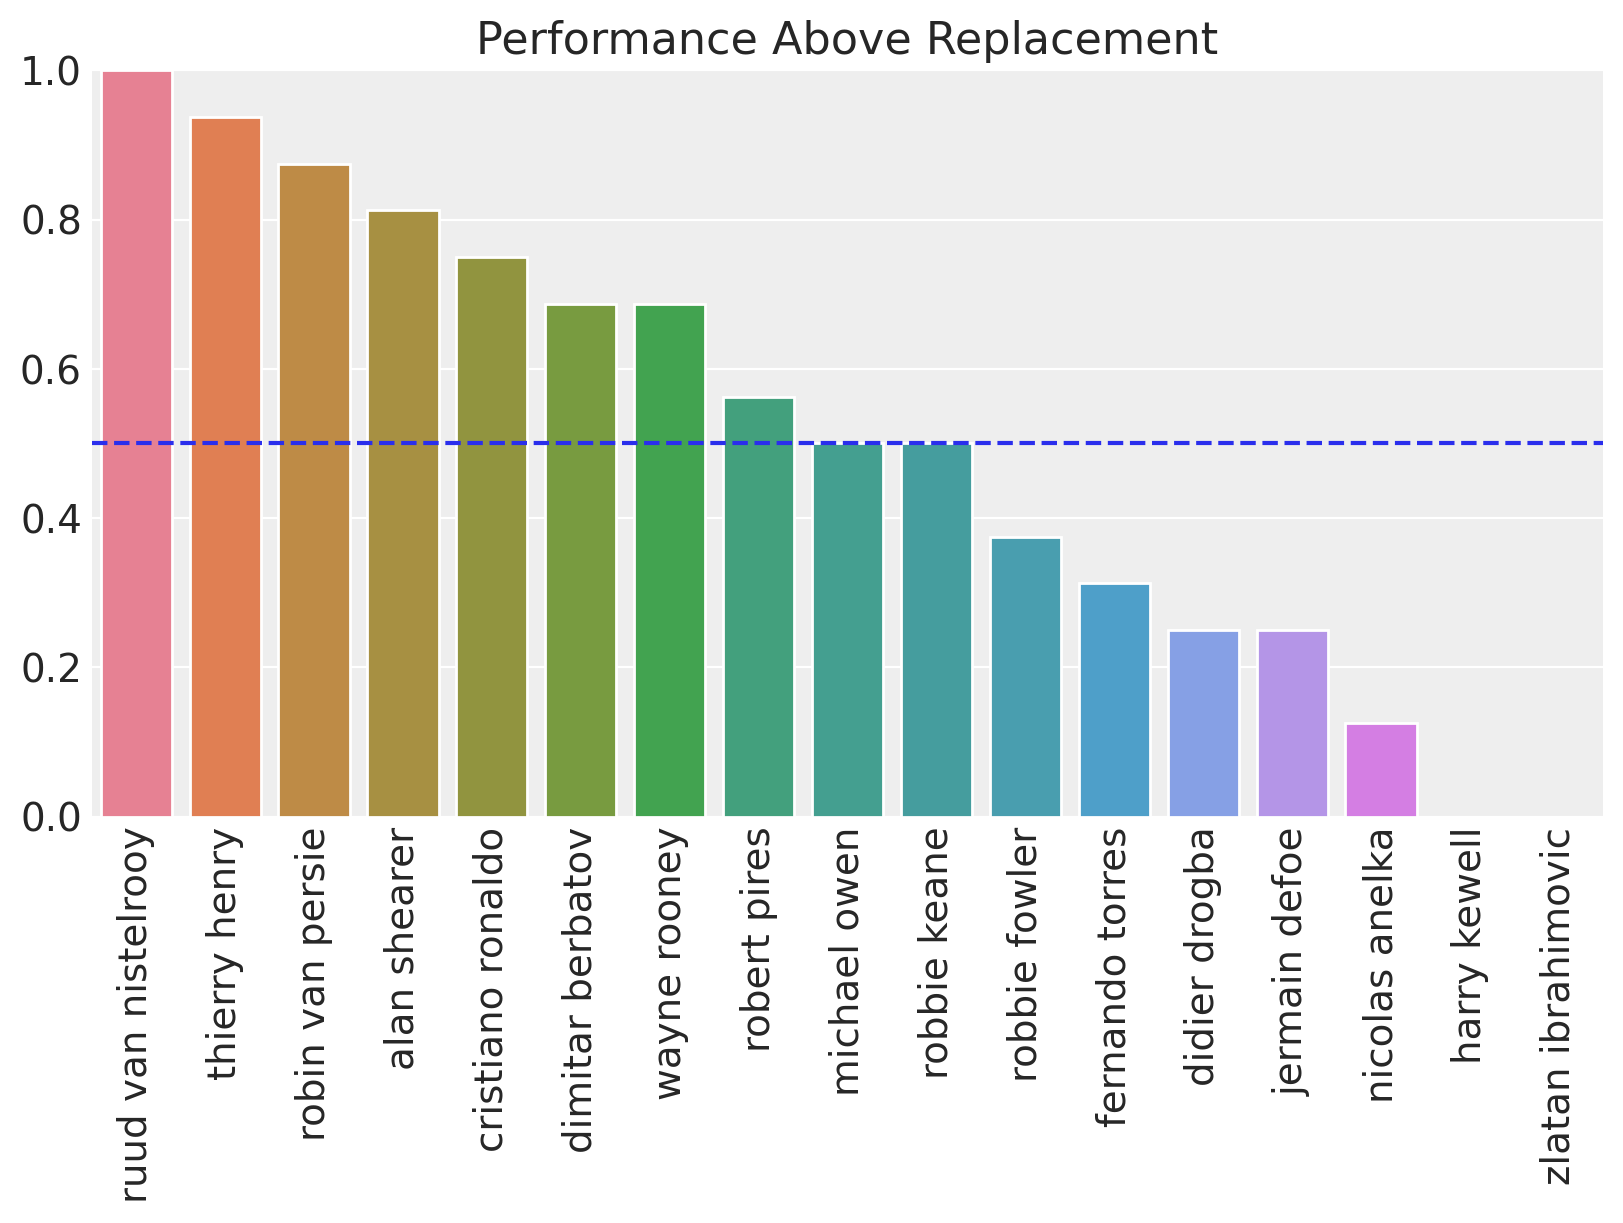

In [29]:
# ================================== Plot PAR for each Player ================================== #

""" ------------------------ Estimation based on 'Option 2' ------------------------ """

df_PAR = pd.DataFrame({'name_player':[pp for pp in list(dict_PAR.keys())],'PAR':[dict_PAR[pp]['PAR_pp'] for pp in list(dict_PAR.keys())]}).sort_values('PAR', ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(df_PAR, x='name_player', y='PAR', hue='name_player', ax=ax)
ax.axhline(0.5, ls='--')
plt.ylim(0,1)
plt.ylabel('')
plt.xlabel('')
ax.tick_params(axis='x', labelrotation=90)
plt.title('Performance Above Replacement')
plt.show()


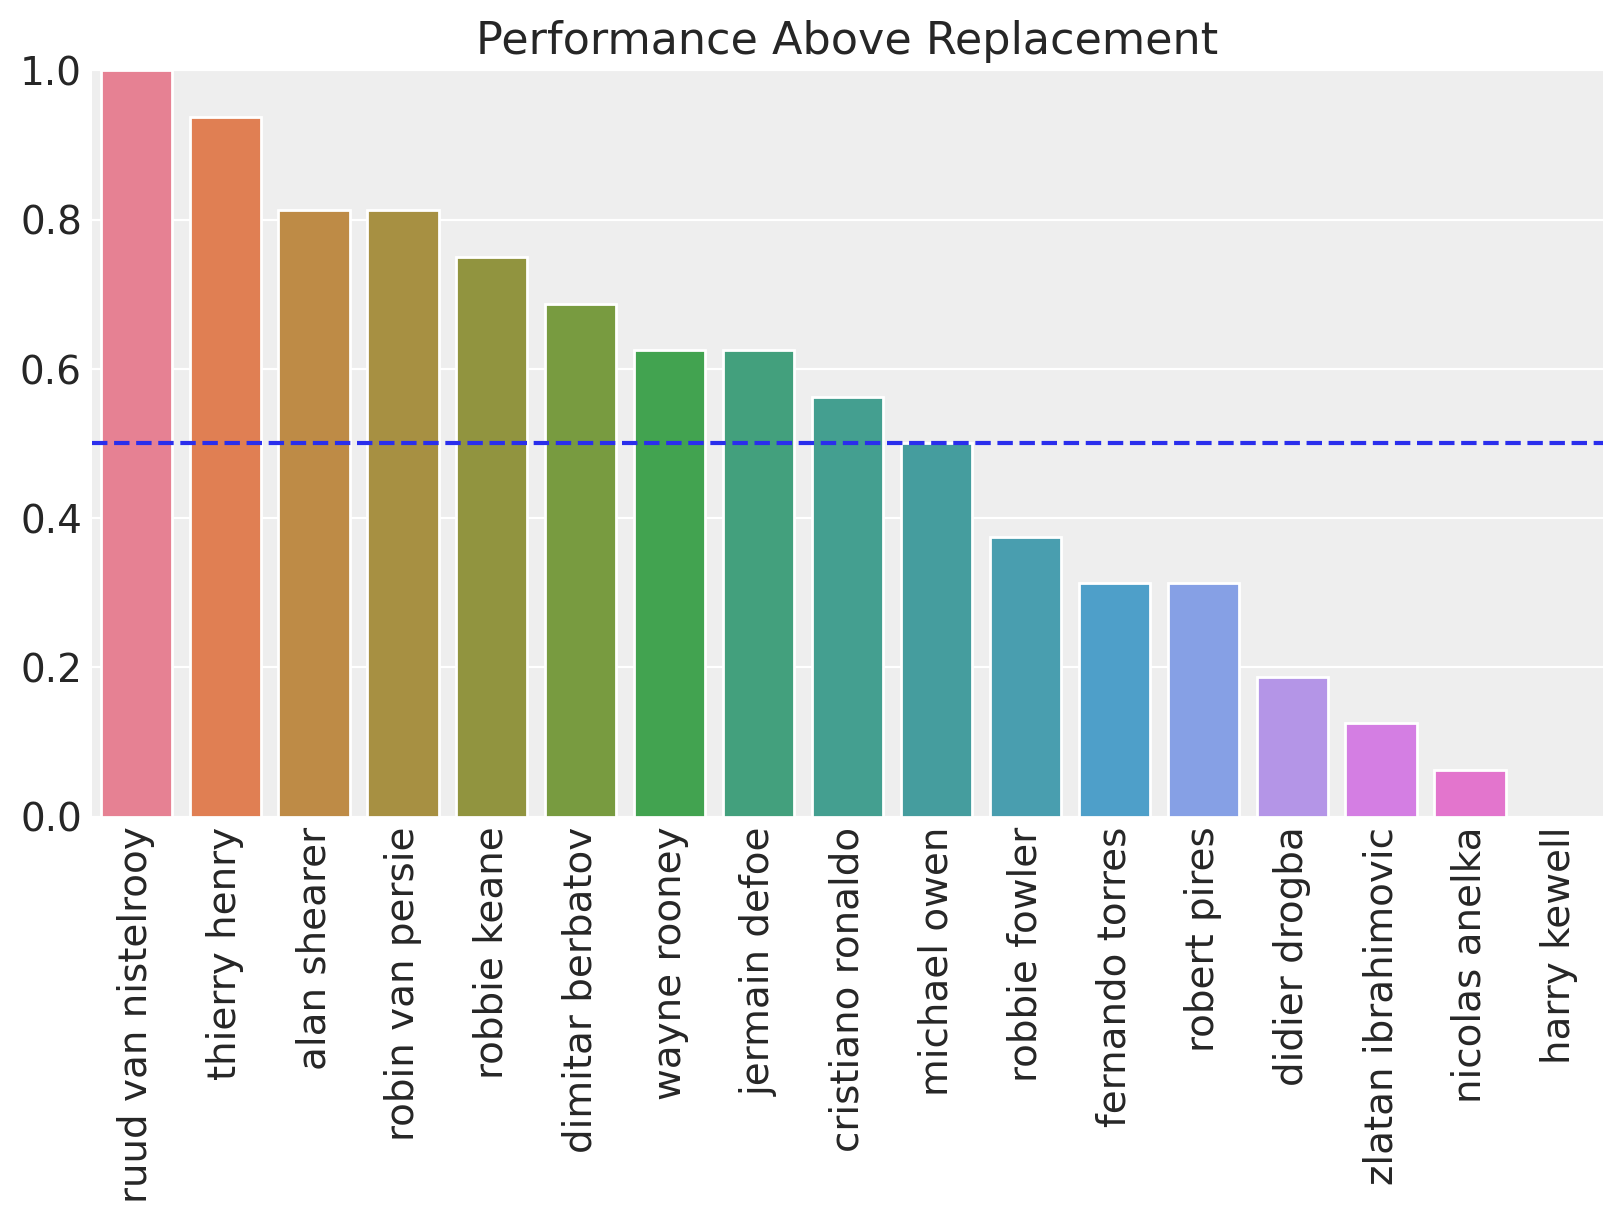

In [73]:
# ================================== Plot PAR for each Player ================================== #

""" ------------------------ Estimation based on 'Option 1' ------------------------ """

df_PAR = pd.DataFrame({'name_player':[pp for pp in list(dict_PAR.keys())],'PAR':[dict_PAR[pp]['PAR_pp'] for pp in list(dict_PAR.keys())]}).sort_values('PAR', ascending=False)

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(df_PAR, x='name_player', y='PAR', hue='name_player', ax=ax)
ax.axhline(0.5, ls='--')
plt.ylim(0,1)
plt.ylabel('')
plt.xlabel('')
ax.tick_params(axis='x', labelrotation=90)
plt.title('Performance Above Replacement')
plt.show()
